C:\Users\bre49823\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


136 68 204
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                4720      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 4,741
Trainable params: 4,741
Non-trainable params: 0
_________________________________________________________________
None
Train on 136 samples, validate on 68 samples
Epoch 1/10
136/136 [==============================] - 1s - loss: 0.2103 - acc: 0.7721 - val_loss: 0.0960 - val_acc: 1.0000
Epoch 2/10
136/136 [==============================] - 0s - loss: 0.1819 - acc: 0.7941 - val_loss: 0.0573 - val_acc: 1.0000
Epoch 3/10
136/136 [==============================] - 0s - loss: 0.1801 - acc: 0.8015 - val_loss:

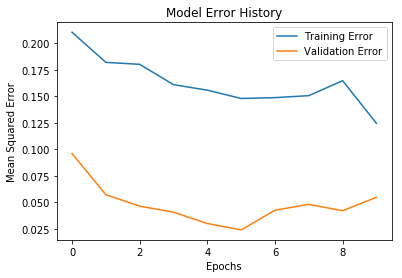

In [7]:
"""
This is a trained Recurrent Neural Network (LSTM) to predict Brent price

Guide to Keras:
    https://keras.io/getting-started/sequential-model-guide/#training

@author: valentin
"""

## Import the functions and classes we'll need
import winsound

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import backend as K

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error



########### Assign values to parameters

# Number of epochs to run
_epochs = 10


# Read in the data
dataLocation = "C:/Projects/EAA/Development/Model/"

brentPriceDf = pd.read_csv(dataLocation + "input_variables.csv")
brentPriceDf.head(10)

# Remove the forecasts from the data
# inputData.BrentPrice[[inputData.Date > 2017-01-01 00:00:00]] = 0

# Format "Date" field as date
brentPriceDf[['date']] = pd.to_datetime(brentPriceDf.date)

# Convert the data frame to a Numpy array
brentPriceArr = brentPriceDf.iloc[:, 0:].values


#####################################################
#####################################################
# Select random seed
randSeed = 789

# Provide names of input features
inputDataFrame = brentPriceDf
inputData = brentPriceArr

# Create a Numpy array from the input data
dataframe = inputData[:, 1:, ]
# xVarColumns = [1, 2, 3]                                   # Select features: BY DEFAULT, it uses all features in columns 1:END for predictors
yVarColumns = [0]                                           # select target: The target should always be in the first column
number_of_features = len(list(brentPriceDf)) - 2            # Calculate the number of features to be used in the network



#####################################################
#####################################################
# fix random seed for reproducibility
np.random.seed(randSeed)


## NO NEED FOR ARRAYS - Extract the NumPy array from the dataframe and convert the integer values to
# floating point values, which are more suitable for modeling with a neural network
# dataset = dataframe.values
# dataset = dataset.astype('float32')

# Normalize the data between 0 - 1
scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
dataset = scaler.fit_transform(dataframe)

# Split the data in train and validaiton
trainSize = int(len(dataset) * 2 / 3)
train = dataset[0:trainSize, :]
validate = dataset[trainSize:len(dataset), :]

print(len(train), len(validate), len(dataset))

## Modify the data for the LSTM network - The LSTM network expects the input data (X)
# to be provided with a specific array structure in the form of: [samples, time steps, features].
trainX = train[:, 1:]
validateX = validate[:, 1:]

trainY = train[:, yVarColumns]
validateY = validate[:, yVarColumns]

dataframe_length = len(trainY)
# dataframe_dim = Need to figure out how to count the columns of the array

# reshape input to be [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
validateX = validateX.reshape(validateX.shape[0], 1, validateX.shape[1])


## The LSTM network expects the input data (X) to be provided with a specific
# array structure in the form of: [samples, time steps, features]
# Define the network
modelFit = Sequential()
modelFit.add(LSTM(20,
                  activation = 'sigmoid',                            # sigmoid, relu, linear, softmax
                  input_shape = (1, number_of_features)))
modelFit.add(Dropout(.1))
modelFit.add(Dense(1, activation = 'linear'))

# Before training the model, configure the learning process via the compile method
modelFit.compile(optimizer = 'adagrad',                              # adam, adagrad
                 loss = 'mean_squared_error',                        # poisson, mean_squared_error, binary_crossentropy
                 metrics = ['accuracy'])

print(modelFit.summary())

# Train the model
modelEstimate = modelFit.fit(trainX, trainY,
                             epochs = _epochs,
                             batch_size = 1,
                             verbose = 1,
                             validation_data = (validateX, validateY))

# make predictions
trainPredict = modelFit.predict(trainX)
validatePredict = modelFit.predict(validateX)

# print the training accuracy and validation loss at each epoch
# print the number of models of the network
print(modelEstimate.history)
print(len(modelFit.layers))


# Invert predictions
df_train = np.column_stack((trainPredict, train[:, 1:]))
trainPredict2 = scaler.inverse_transform(df_train)

df_validate = np.column_stack((validatePredict, validate[:, 1:]))
validatePredict2 = scaler.inverse_transform(df_validate)


# Plot the errors of the epochs and MSE
plt.plot(modelEstimate.history['loss'])
plt.plot(modelEstimate.history['val_loss'])
#  plt.plot(modelEstimate.history['val_acc'])
plt.title('Model Error History')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend(['Training Error', 'Validation Error'])
plt.show()
    

###################################################
# Combine the final datasest - merge the training and validation datasets and rename columns
combined_dataframe = pd.concat([pd.DataFrame(trainPredict2), pd.DataFrame(validatePredict2)])
combined_dataframe.index = range(len(combined_dataframe))

# Add columns names to the data frame with the forecasts
names_list = list(inputDataFrame)[1:]
names_list[0] = 'forecast_brent_price'

combined_dataframe.columns = names_list

actual_value_target = pd.DataFrame(dataframe[:, 0])
actual_value_target.columns = ['actual_brent_price']


# Create the dataframe and write it to a CSV file
final_forecast_file = pd.concat([actual_value_target, combined_dataframe], axis = 1)
final_forecast_file.to_csv(dataLocation + "Brent_forecast.csv", sep = ',')


# Beep when done with code
winsound.Beep(750, 200)



